In [1]:
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# Problem T1.1 data
# -----------------------------
def airy_data():
    x = np.array([-2., -1., 0., 1., 2.])
    y = np.array([0.227407, 0.535561, 0.355028, 0.135292, 0.034924])
    return x, y


# -----------------------------
# Interpolation: degree-4 polynomial through 5 points
# P4(x) = a0 + a1 x + a2 x^2 + a3 x^3 + a4 x^4
# Solve Vandermonde system
# -----------------------------
def poly_interpolation_degree4(x, y):
    # Vandermonde with increasing powers: [1, x, x^2, x^3, x^4]
    V = np.vander(x, N=5, increasing=True)
    a = np.linalg.solve(V, y)
    return a  # a[0]=a0, ..., a[4]=a4


def poly_eval(coeffs, x):
    # coeffs = [c0, c1, ..., ck] for c0 + c1 x + ...
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    # Horner for stability/readability
    for c in reversed(coeffs):
        y = y * x + c
    return y


# -----------------------------
# Least squares fit: quadratic y(x)= b0 + b1 x + b2 x^2
# Build normal equations (A^T A)b = A^T y
# -----------------------------
def least_squares_quadratic_normal_eq(x, y):
    A = np.column_stack([np.ones_like(x), x, x**2])  # n x 3
    ATA = A.T @ A
    ATy = A.T @ y
    b = np.linalg.solve(ATA, ATy)
    return b  # b[0]=b0, b[1]=b1, b[2]=b2


def plot_t11(x, y, a_interp, b_ls):
    xx = np.linspace(-2, 2, 400)
    yy_interp = poly_eval(a_interp, xx)
    yy_ls = poly_eval(b_ls, xx)

    plt.figure()
    plt.plot(xx, yy_interp, label="Interpolation P4(x)")
    plt.plot(xx, yy_ls, label="Least Squares Quadratic y(x)")
    plt.plot(x, y, "o", label="Given 5 points")
    plt.xlabel("x")
    plt.ylabel("Ai(x) (given data)")
    plt.title("T1.1: Interpolation vs Least Squares Fit")
    plt.grid(True)
    plt.legend()
    plt.show()


def solve_t11():
    x, y = airy_data()

    a_interp = poly_interpolation_degree4(x, y)
    b_ls = least_squares_quadratic_normal_eq(x, y)

    print("=== T1.1 Results ===")
    print("Interpolation coefficients a (P4):")
    for i, c in enumerate(a_interp):
        print(f"  a{i} = {c:.10f}")

    print("\nLeast squares coefficients b (quadratic):")
    for i, c in enumerate(b_ls):
        print(f"  b{i} = {c:.10f}")

    plot_t11(x, y, a_interp, b_ls)


=== T1.1 Results ===
Interpolation coefficients a (P4):
  a0 = 0.3550280000
  a1 = -0.2508057500
  a2 = -0.0074801250
  a3 = 0.0506712500
  a4 = -0.0121213750

Least squares coefficients b (quadratic):
  b0 = 0.3799634000
  b1 = -0.0785235000
  b2 = -0.0611605000


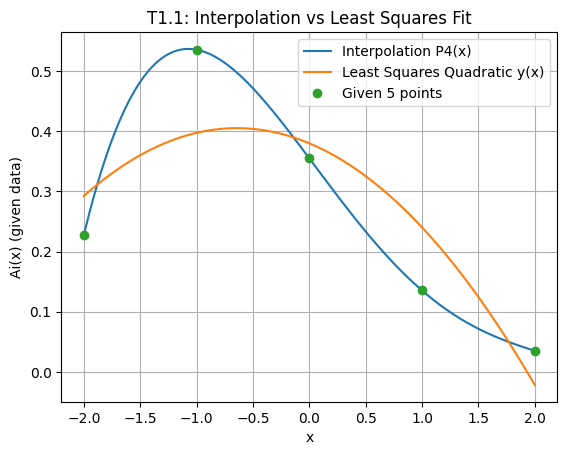

In [2]:
solve_t11()

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# T1.2: define y(x) and f(x) for x>0
# From the PDF's simplification (page 3):
# y = (4 - x) / (4 - 2*sqrt(x))
# f(x) = x^2 + x/(4 - sqrt(x)) - 1
# -----------------------------
def y_from_x(x):
    x = float(x)
    if x <= 0:
        raise ValueError("This reduced formula assumes x > 0.")
    s = np.sqrt(x)
    denom = 4 - 2*s
    if abs(denom) < 1e-14:
        raise ZeroDivisionError("Denominator 4 - 2*sqrt(x) too close to zero.")
    return (4 - x) / denom


def f(x):
    x = float(x)
    if x <= 0:
        # not in our reduced domain
        return np.nan
    s = np.sqrt(x)
    denom = 4 - s
    if abs(denom) < 1e-14:
        return np.nan
    return x**2 + x / denom - 1.0


def fprime(x):
    """
    Derivative of f(x)= x^2 + x/(4 - sqrt(x)) - 1 for x>0.
    Let s = sqrt(x). Then denom = 4 - s.
    d/dx [x/(4 - s)] = (4 - s)^(-1) + x * d/dx[(4 - s)^(-1)]
    d/dx[(4 - s)^(-1)] = (4 - s)^(-2) * (1/(2*sqrt(x))) = (4 - s)^(-2) * (1/(2*s))
    So:
    f'(x)= 2x + 1/(4 - s) + x * (1/(2*s*(4 - s)^2))
    """
    x = float(x)
    if x <= 0:
        return np.nan
    s = np.sqrt(x)
    denom = 4 - s
    if abs(denom) < 1e-14 or s == 0:
        return np.nan
    return 2*x + 1/denom + x * (1/(2*s*(denom**2)))


# -----------------------------
# Root-finding methods
# -----------------------------
def bisection(func, a, b, tol=1e-10, max_iter=200):
    fa, fb = func(a), func(b)
    if not np.isfinite(fa) or not np.isfinite(fb):
        raise ValueError("f(a) or f(b) is not finite.")
    if fa * fb > 0:
        raise ValueError("Bisection requires a sign change on [a,b].")

    for _ in range(max_iter):
        m = 0.5 * (a + b)
        fm = func(m)
        if not np.isfinite(fm):
            raise ValueError("f(mid) is not finite; interval may cross a singularity.")
        if abs(fm) < tol or 0.5 * (b - a) < tol:
            return m
        if fa * fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm
    return 0.5 * (a + b)


def newton(func, dfunc, x0, tol=1e-10, max_iter=50):
    x = float(x0)
    for _ in range(max_iter):
        fx = func(x)
        dfx = dfunc(x)
        if not np.isfinite(fx) or not np.isfinite(dfx) or abs(dfx) < 1e-14:
            raise ValueError("Newton failed due to non-finite value or near-zero derivative.")
        x_new = x - fx / dfx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    return x


def secant(func, x0, x1, tol=1e-10, max_iter=80):
    x_prev, x = float(x0), float(x1)
    f_prev, f_curr = func(x_prev), func(x)
    for _ in range(max_iter):
        if not np.isfinite(f_prev) or not np.isfinite(f_curr):
            raise ValueError("Secant encountered non-finite function value.")
        denom = (f_curr - f_prev)
        if abs(denom) < 1e-14:
            raise ValueError("Secant failed due to nearly zero denominator.")
        x_new = x - f_curr * (x - x_prev) / denom
        if abs(x_new - x) < tol:
            return x_new
        x_prev, f_prev = x, f_curr
        x, f_curr = x_new, func(x_new)
    return x


# -----------------------------
# Helper: find a bracketing interval automatically on (0, 2]
# (Circle radius is sqrt(2); intersection x should be within a small range.)
# We'll scan for sign change safely.
# -----------------------------
def find_bracket(func, x_min=1e-6, x_max=2.0, n=4000):
    xs = np.linspace(x_min, x_max, n)
    prev_x = xs[0]
    prev_f = func(prev_x)
    for x in xs[1:]:
        fx = func(x)
        if np.isfinite(prev_f) and np.isfinite(fx) and prev_f * fx < 0:
            return prev_x, x
        prev_x, prev_f = x, fx
    raise ValueError("No sign change found in the scan interval; adjust x_min/x_max.")


def solve_t12():
    """
    Solve the intersection points between the heart curve and the circle.
    We solve for x>0, then use symmetry to obtain the second point.
    """

    print("=== T1.2 Results ===")

    # -----------------------------
    # Step 1: find positive root by bisection
    # -----------------------------
    a, b = find_bracket(f, x_min=1e-6, x_max=2.0, n=4000)
    x_bis = bisection(f, a, b)

    # -----------------------------
    # Step 2: Newton method
    # -----------------------------
    x_newt = newton(f, fprime, x0=2.0)

    # -----------------------------
    # Step 3: Secant method
    # -----------------------------
    x_sec = secant(f, 1.2, 1.6)

    # -----------------------------
    # Helper: compute two symmetric points
    # -----------------------------
    def compute_points(x_root):
        y_root = y_from_x(x_root)

        # positive-x intersection
        p_pos = ( x_root, y_root)

        # symmetry: (-x, y)
        p_neg = (-x_root, y_root)

        return p_neg, p_pos

    # -----------------------------
    # Print results neatly
    # -----------------------------
    def report(name, xr):
        p1, p2 = compute_points(xr)

        print(f"\n{name}:")
        print(f"  positive root x* = {xr:.10f}")
        print(f"  intersection points:")
        print(f"    (x1, y1) = ({p1[0]:.10f}, {p1[1]:.10f})")
        print(f"    (x2, y2) = ({p2[0]:.10f}, {p2[1]:.10f})")

    report("Bisection Method", x_bis)
    report("Newton Method", x_newt)
    report("Secant Method", x_sec)

    # -----------------------------
    # Optional sanity plot
    # -----------------------------
    xx = np.linspace(1e-4, 2.0, 1000)
    ff = np.array([f(t) for t in xx])

    plt.figure()
    plt.plot(xx, ff)
    plt.axhline(0, linewidth=1)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("T1.2: Root of reduced equation f(x)=0")
    plt.grid(True)
    plt.show()


# If you want to run just T1.2:
# solve_t12()


=== T1.2 Results ===

Bisection Method:
  positive root x* = 0.8506512037
  intersection points:
    (x1, y1) = (-0.8506512037, 1.4611537714)
    (x2, y2) = (0.8506512037, 1.4611537714)

Newton Method:
  positive root x* = 0.8506512037
  intersection points:
    (x1, y1) = (-0.8506512037, 1.4611537715)
    (x2, y2) = (0.8506512037, 1.4611537715)

Secant Method:
  positive root x* = 0.8506512037
  intersection points:
    (x1, y1) = (-0.8506512037, 1.4611537715)
    (x2, y2) = (0.8506512037, 1.4611537715)


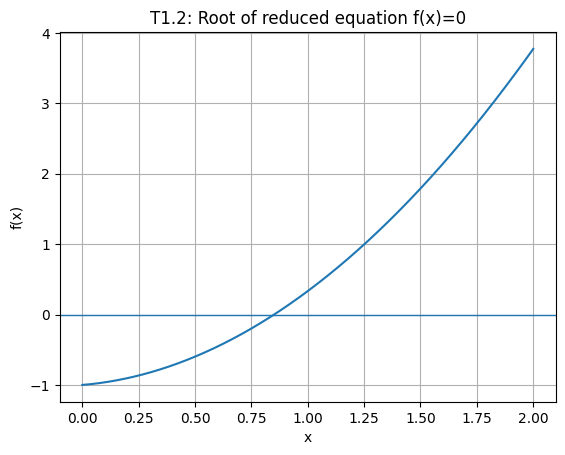

In [6]:
solve_t12()